# CellAlign DTW alignment and TrAGEDy post-hoc processed DTW alignment - Ref/ATO and Healthy/IPF tests

### Installed and followed documentation of CellAlign from https://github.com/shenorrLabTRDF/cellAlign
CellAlign reference: Alpert, A., Moore, L.S., Dubovik, T. and Shen-Orr, S.S., 2018. Alignment of single-cell trajectories to compare cellular expression dynamics. Nature methods, 15(4), pp.267-270.
### Used source and followed documentation of TrAGEDy from https://github.com/No2Ross/TrAGEDy
TrAGEDy reference: Laidlaw, R.F., Briggs, E.M., Matthews, K.R., McCulloch, R. and Otto, T.D., 2022. TrAGEDy: Trajectory Alignment of Gene Expression Dynamics. bioRxiv, pp.2022-12.

In [52]:
 packageVersion("cellAlign")

[1] ‘0.1.0’

In [1]:
suppressMessages({library(sceasy)
library(r2r)
library(reticulate)
library(pheatmap)
library(cellAlign)
library(r2r)
library(RColorBrewer)
library(Seurat)
library(SingleCellExperiment)
library(ggplot2)
library(dplyr)
library(stats)
library(stringr)           
})
# Source ref:
# https://github.com/No2Ross/TrAGEDy/blob/304dd27949858748c1bce04bf22dd8b6a1d159b3/TrAGEDy_functions.R
source("TrAGEDy/TrAGEDy_functions.R")
#source("TrAGEDy/TrAGEDy_functions)old.R")

#py_install("anndata") # <--- did this and reticulate started to work without any error 
##reticulate::use_condaenv("../my-conda-envs/r-sceasy")
#reticulate::py_discover_config() <-- reticulate path is r-miniconda python which is different from conda env python -- need to check how to change it
# otherwise it works only for anndata v0.75 format
#R = sceasy::convertFormat('../[G2G]New_scripts/SimulationData/ref_Div05.h5ad', from="anndata", to="seurat")

# Function to generate 3-state alignment string from CellAlign DTW alignment output
get_3_state_alignment_str <- function(alignment){

    T_matched <- alignment$align[[1]]$index1 # query in index 1
    S_matched <- alignment$align[[1]]$index2 # ref in index 2
    
    prev_Sc = ''
    prev_Tc = ''
    al_str = ''
    for (x in 1:length(T_matched)) {
        curr_S = S_matched[x]
        curr_T = T_matched[x]

        if(prev_Sc == '' & prev_Tc==''){
            al_str = paste(al_str, 'M')
        }else if(curr_S == prev_Sc){ # warp insert 
            al_str = paste(al_str, 'V')
        }else if(curr_T == prev_Tc){ # warp delete 
            al_str = paste(al_str, 'W')
        }else{
            al_str = paste(al_str, 'M')
        }
      prev_Sc = S_matched[x]
      prev_Tc = T_matched[x]
    } 
    return(al_str)
}
# plotting function from CellAlign --- only modified to plot a black color alignment path
plotAlign <- function(alignment){

  costMat = alignment$localCostMatrix
  costMat = t(apply(costMat,1,function(x){return(as.numeric(x))}))
  linearInd = cellAlign::sub2ind(nrow(costMat), alignment$align[[1]]$index1, alignment$align[[1]]$index2)
  costMat[linearInd] = NA
  costMat = data.frame(costMat, row.names=1:nrow(costMat))
  colnames(costMat) = 1:ncol(costMat)
    
  #for global alignment, where there is a pseudotime shift vector:
  if(!is.null(alignment$ptShift)){
    annotCols = data.frame(ptShift = abs(alignment$ptShift),row.names = colnames(costMat))

    phm = pheatmap(costMat, cluster_cols = F, cluster_rows=F, border_color = NA, main = 'alignment plot',
             show_rownames = T, show_colnames = T, annotation_col = annotCols,na_col = "black")#, filename=filename)

  }else{
    phm = pheatmap(costMat, cluster_cols = F, cluster_rows=F, border_color = NA, main = 'alignment plot', 
                   show_rownames = T, show_colnames = T,na_col = "black")#, filename=filename)
  }
}
# plotting function from CellAlign --- only modified to plot a black color alignment path
plotAlign2 <- function(alignment){

  costMat = alignment$localCostMatrix
  costMat = t(apply(costMat,1,function(x){return(as.numeric(x))}))
  #linearInd = sub2ind(nrow(costMat), alignment$align[[1]]$index1, alignment$align[[1]]$index2)
  #costMat[linearInd] = NA
  costMat = data.frame(costMat, row.names=1:nrow(costMat))
  colnames(costMat) = 1:ncol(costMat)
    
  #for global alignment, where there is a pseudotime shift vector:
  if(!is.null(alignment$ptShift)){
    annotCols = data.frame(ptShift = abs(alignment$ptShift),row.names = colnames(costMat))

    phm = pheatmap(costMat, cluster_cols = F, cluster_rows=F, border_color = NA, main = 'alignment plot',
             show_rownames = T, show_colnames = T, annotation_col = annotCols,na_col = "black")#, filename=filename)

  }else{
    phm = pheatmap(costMat, cluster_cols = F, cluster_rows=F, border_color = NA, main = 'alignment plot', 
                   show_rownames = T, show_colnames = T,na_col = "black")#, filename=filename)
  }
}
# plotting function from CellAlign --- only modified to plot a black color alignment path
plotAlign_save <- function(alignment, filename){

  costMat = alignment$localCostMatrix
  costMat = t(apply(costMat,1,function(x){return(as.numeric(x))}))
  linearInd = cellAlign::sub2ind(nrow(costMat), alignment$align[[1]]$index1, alignment$align[[1]]$index2)
  costMat[linearInd] = NA
  costMat = data.frame(costMat, row.names=1:nrow(costMat))
  colnames(costMat) = 1:ncol(costMat)
    
  #for global alignment, where there is a pseudotime shift vector:
  if(!is.null(alignment$ptShift)){
    annotCols = data.frame(ptShift = abs(alignment$ptShift),row.names = colnames(costMat))

    phm = pheatmap(costMat, cluster_cols = F, cluster_rows=F, border_color = NA, main = 'alignment plot',
             show_rownames = T, show_colnames = T, annotation_col = annotCols,na_col = "black", filename=filename)

  }else{
    phm = pheatmap(costMat, cluster_cols = F, cluster_rows=F, border_color = NA, main = 'alignment plot', 
                   show_rownames = T, show_colnames = T,na_col = "black", filename=filename)
  }
}

# wrapper function to run CellAlign high-dimensional alignment on all genes
run_global_dtw <- function(GENE, interGlobalLPS, interGlobalPAM, interScaledGlobalLPS, interScaledGlobalPAM ){
    # ' @param x query data matrix,  @param y reference data matrix
    # columns --- PAM (REFERENCE)
    # rows --- LPS (QUERY)
    alignment = cellAlign::globalAlign(interGlobalLPS$interpolatedVals[GENE,], interGlobalPAM$interpolatedVals[GENE,],
                                       scores = list(query = interScaledGlobalLPS$traj, 
                                                     ref = interScaledGlobalPAM$traj),
                                       sigCalc = F, numPerm = 20)
    return(alignment)
}

# wrapper function to run CellAlign high-dimensional alignment on all genes
run_global_dtw_all_genes <- function(interGlobalLPS, interGlobalPAM, interScaledGlobalLPS, interScaledGlobalPAM ){
    # ' @param x query data matrix,  @param y reference data matrix
    # columns --- PAM (REFERENCE)
    # rows --- LPS (QUERY)
    alignment = cellAlign::globalAlign(interGlobalLPS$interpolatedVals, interGlobalPAM$interpolatedVals,
                                       scores = list(query = interScaledGlobalLPS$traj, 
                                                     ref = interScaledGlobalPAM$traj),
                                       sigCalc = F, numPerm = 20)
    return(alignment)
}

# function to get the 5-state string described by TrAGEDy alignment
get_5_state_alignment_str <- function(path_cut){
    # ref: path_cut$X (WT)
    # query: path_cut$Y (KO)
    timepoints_S <- strsplit(path_cut$X,'_')
    timepoints_T <- strsplit(path_cut$Y,'_')
    if(length(timepoints_S) != length(timepoints_T)){
       stop("error message to print")   
    }
    prev_tS = -1
    prev_tT = -1
    al_str <- ''
    for (i in 1:length(timepoints_S)){
        tS = strtoi(timepoints_S[i][[1]][2])
        tT = strtoi(timepoints_T[i][[1]][2])

        # process terminal mismatch at the start if exists
        if(i==1){
            if(tS!=1){
                j=1
                while(j<tS){
                    #print('D')
                    al_str <- paste(al_str, 'D')
                    j<-j+1
                }
            }
            if(tT!=1){
                j=1
                while(j<tT){
                    #print('I')
                    al_str <- paste(al_str, 'I')
                    j<-j+1
                }
            }
        }
        if(path_cut$Status[i]=='match'){
            if(prev_tT == tT){
                #print(paste('W',' ',tS,' ',tT))
                al_str <- paste(al_str, 'W')
            }else if(prev_tS==tS){
                #print(paste('V',' ',tS,' ',tT))
                al_str <- paste(al_str, 'V')
            }else{
                #print(paste('M',' ',tS,' ',tT))
                al_str <- paste(al_str, 'M')
            }
            prev_tT = tT
            prev_tS = tS

        }else{ # cut
            if(prev_tT != tT){
                #print(paste('I',' ',tT))
                al_str <- paste(al_str, 'I')
            }
            if(prev_tS != tS){
                #print(paste('D',' ',tS))
                al_str <- paste(al_str, 'D')
            }
            prev_tT = tT
            prev_tS = tS
        }
        # process terminal mimatch if exists
        if(i==length(timepoints_S)){
            if(tS!=npts){
                j=1
                while(j<=(npts-tS)){
                    #print(paste('D', ' ',tS))
                    al_str <- paste(al_str, 'D')
                    j<-j+1
                }
            }
            if(tT!=npts){
                j=1
                while(j<= (npts-tT) ){
                    #print(paste('I', ' ',tT))
                    al_str <- paste(al_str, 'I')
                    j<-j+1
                }
            }
        }
    }
    return(al_str)
}


run_tragedy_DTW <- function(GENE, cut_type, distance_metric, plot=FALSE){

    KO_node_exp_mtx_g <- as(matrix(KO_node_exp_mtx[unique(c(GENE)), ], nrow=1), 'dgeMatrix')
    WT_node_exp_mtx_g <- as(matrix(WT_node_exp_mtx[unique(c(GENE)), ], nrow=1), 'dgeMatrix')
    rownames(KO_node_exp_mtx_g) = c(GENE)
    colnames(KO_node_exp_mtx_g) = colnames(KO_node_exp_mtx)
    rownames(WT_node_exp_mtx_g) = c(GENE)
    colnames(WT_node_exp_mtx_g) = colnames(WT_node_exp_mtx)

    distance_metric = 'euclidean'
    dis_matrix <- dis_mtx_calculator(as.matrix(WT_node_exp_mtx_g), as.matrix(KO_node_exp_mtx_g), distance_metric) 
    # NOTE: Spearman does not work for single gene alignment
    path_uncut <- pathfind(dis_matrix, cut_type = cut_type, method = "mean")
    path_cut <- cut_deviate(path_uncut, dis_matrix, method = "mean")
    if(plot){
        PlotOutput(WT_tree, KO_tree, path_cut)
        PlotAlignment(path_cut, dis_matrix)
    }
    return(path_cut)
} 

run_tragedy_DTW_celllevel <- function(WT_node_exp_mtx_g, KO_node_exp_mtx_g, cut_type, distance_metric, plot=FALSE){

    dis_matrix <- dis_mtx_calculator(as.matrix(WT_node_exp_mtx_g), as.matrix(KO_node_exp_mtx_g), distance_metric) 
    # NOTE: Spearman does not work for single gene alignment
    path_uncut <- pathfind(dis_matrix, cut_type = cut_type, method = "mean")
    path_cut <- cut_deviate(path_uncut, dis_matrix, method = "mean")
    #PlotOutput(WT_tree, KO_tree, path_cut)
    if(plot){
        PlotOutput(WT_tree, KO_tree, path_cut)
        PlotAlignment(path_cut, dis_matrix)
    }
    return(path_cut)
    
}

In [2]:
 sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.1 LTS

Matrix products: default
BLAS/LAPACK: /home/jovyan/my-conda-envs/r-sceasy/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] stringr_1.5.1               dplyr_1.0.8                
 [3] ggplot2_3.4.4               SingleCellExperiment_1.16.0
 [5] SummarizedExperiment_1.24.0 Biobase_2.54.0             
 [7] GenomicRanges_1.46.1        GenomeInfoDb_1.30.1        
 [9] IRanges_2.28.0              S4Vectors_0.3

# Additional test -- for SP T lineage 

In [45]:
numPts = 14
npts = numPts
R = sceasy::convertFormat('g2g_datasets_to_test/adata_ref_spt.h5ad', from="anndata", to="seurat")
Q = sceasy::convertFormat('g2g_datasets_to_test/adata_ato_spt.h5ad', from="anndata", to="seurat")
R_data = R@assays$RNA@data
Q_data = Q@assays$RNA@data
R_time = R$time
Q_time = Q$time

X -> counts

X -> counts



In [51]:
#R@meta.data[,'ANNOTATION_COMB']
#Q@meta.data[,'ANNOTATION_COMB']

In [46]:
# CellAlign
interGlobalPAM = cellAlign::interWeights(expDataBatch = R_data, trajCond = R_time,
                                             winSz = 0.1, numPts = numPts)
interGlobalLPS = cellAlign::interWeights(expDataBatch = Q_data, trajCond = Q_time,
                                                 winSz = 0.1, numPts = numPts)
interScaledGlobalLPS = cellAlign::scaleInterpolate(interGlobalLPS)
interScaledGlobalPAM = cellAlign::scaleInterpolate(interGlobalPAM)

# Chekcking HHEX DTW alignment (for G2G manuscript Fig 3a)
#alignment = suppressMessages(run_global_dtw('HHEX', interGlobalLPS, interGlobalPAM, interScaledGlobalLPS, interScaledGlobalPAM )) 
#al_str = get_3_state_alignment_str(alignment)
#print(paste('CellAlign DTW alignment: HHEX: ', al_str))
# Checking all TFs
alignment = suppressMessages(run_global_dtw_all_genes(interGlobalLPS, interGlobalPAM, interScaledGlobalLPS, interScaledGlobalPAM )) 
al_str = get_3_state_alignment_str(alignment)
print(paste('CellAlign DTW alignment: all: ', al_str))


[1] "CellAlign DTW alignment: all:   M V V V V V V M W M W W W V W W W M W V V V W W"


In [4]:
# TrAGEDy 
source("TrAGEDy/TrAGEDy_functions.R")
pseudo_end <- min(c(max(Q_time, R_time)))
window <- 0.1 # we use 0.1 the same window size for benchmarking (as CellAlign, G2G also use that as default)
WT_cell_pseudotime <- matrix(R_time, dimnames =list(row.names(R@meta.data)  ))
KO_cell_pseudotime <- matrix(Q_time, dimnames =list(row.names(Q@meta.data)  ))
WT_ID <- data.frame(R@meta.data$ANNOTATION_COMB, row.names =row.names(R@meta.data))
KO_ID <- data.frame(Q@meta.data$ANNOTATION_COMB, row.names =row.names(Q@meta.data))
WT_tree <- nodePseudotime(WT_cell_pseudotime,WT_ID, numPts, "WT")
KO_tree <- nodePseudotime(KO_cell_pseudotime,KO_ID, numPts, "KO")

Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”


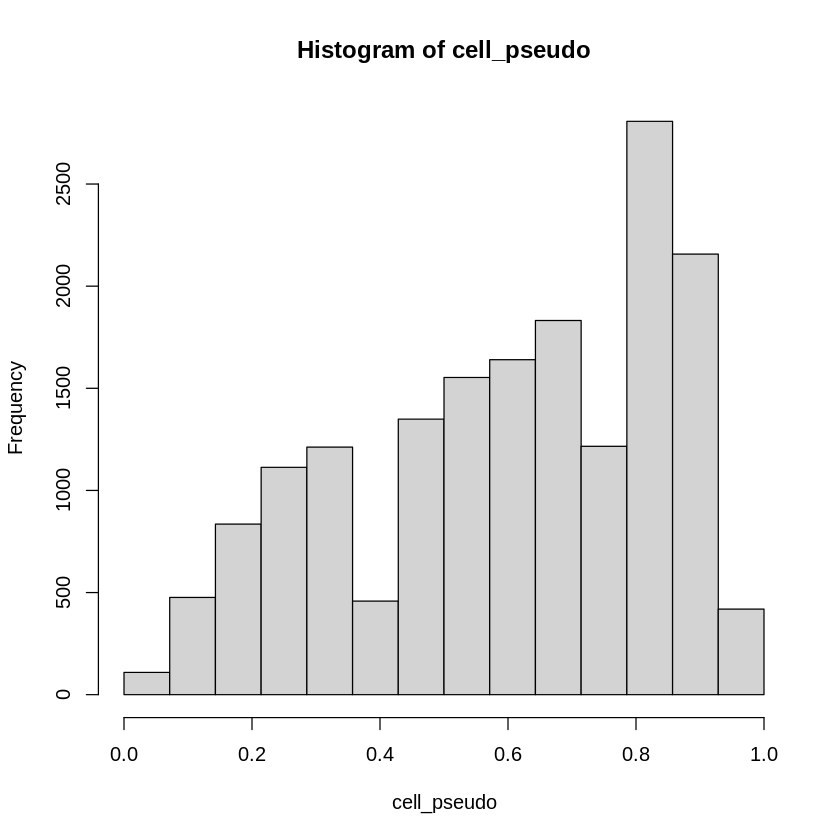

[1]  1371 20327

[1]  1371 17176

[1] "TrAGEDy DTW alignment [minimum cut - euclidean]: HHEX:   D D D I D I I V V I I I V M W M W W W W M M M"
[1] "The mean score of your optimal path is 3.58022714335218. You should consider whether or not these two processes share a common process"


Warning message in get_thresholds(alignment, dis_mtx, method):
“NAs introduced by coercion”
Warning message in get_thresholds(alignment, dis_mtx, method):
“NAs introduced by coercion”


[1] "TrAGEDy DTW alignment [minimum cut - euclidean]: all  I I I I I I M M M W W W W M W W M I D I D I D"


Warning message in if (index_choice == 1) {:
“the condition has length > 1 and only the first element will be used”
Warning message in get_thresholds(alignment, dis_mtx, method):
“NAs introduced by coercion”
Warning message in get_thresholds(alignment, dis_mtx, method):
“NAs introduced by coercion”


[1] "TrAGEDy DTW alignment [minimum cut - spearman]: all  I I I I I I M M M W M W W W W W M M M M"


png 
  2

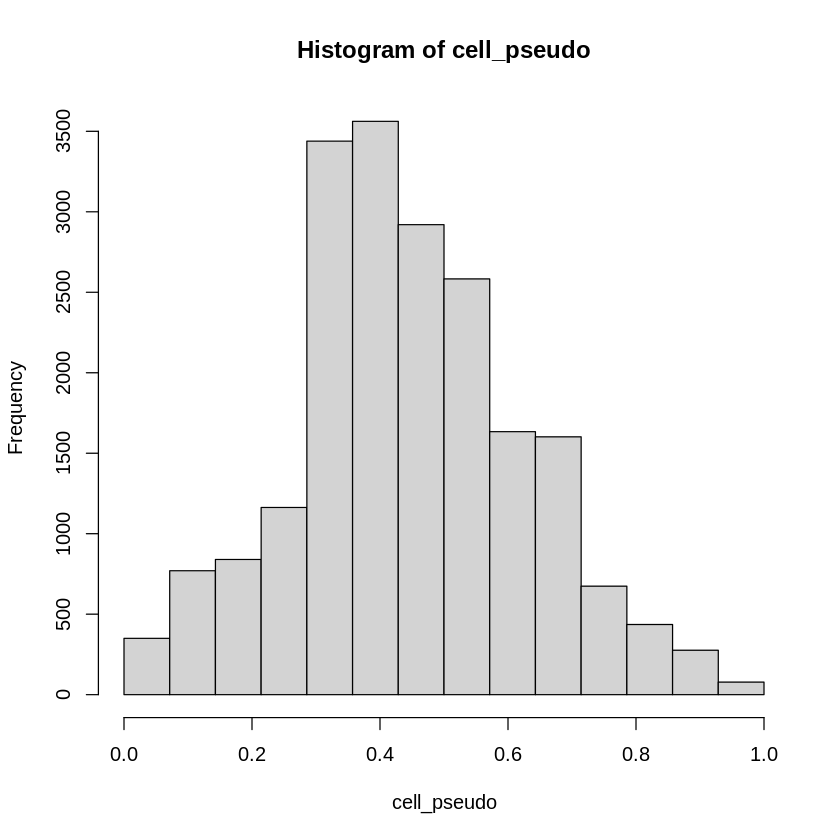

In [5]:

KO_cell_pseudo <- data.frame("ID" = row.names(Q@meta.data), "pseudo" =  Q_time)
KO_node_pseudo <- data.frame("ID" = row.names(KO_tree$pseudotime), "pseudo" = KO_tree$pseudotime$pseudotime)
WT_cell_pseudo <- data.frame("ID" = row.names(R@meta.data), "pseudo" = R_time)
WT_node_pseudo <- data.frame("ID" = row.names(WT_tree$pseudotime), "pseudo" = WT_tree$pseudotime$pseudotime)
KO_node_pseudotime <- matrix(KO_tree$pseudotime$pseudotime , dimnames = list(row.names(KO_tree$pseudotime)), )
WT_node_pseudotime <- matrix(WT_tree$pseudotime$pseudotime , dimnames = list(row.names(WT_tree$pseudotime)), )
#Get gene expression values for the interpolated points
KO_node_exp_mtx <- nodeExpressionEstimate(Q_data, KO_node_pseudotime, KO_cell_pseudotime, window, adjust.window = T)
WT_node_exp_mtx <- nodeExpressionEstimate(R_data, WT_node_pseudotime, WT_cell_pseudotime, window, adjust.window = T)

dim(R)
dim(Q)

dev.new()

cut_type = 'minimum'
distance_metric = 'euclidean'
alignment <- suppressWarnings(run_tragedy_DTW('HHEX', cut_type = cut_type, distance_metric=distance_metric))
al_str <- get_5_state_alignment_str(alignment)
print(paste('TrAGEDy DTW alignment [minimum cut - euclidean]: HHEX: ', al_str))

cut_type = 'minimum'
distance_metric = 'euclidean'
alignment <- run_tragedy_DTW_celllevel(WT_node_exp_mtx, KO_node_exp_mtx, cut_type = cut_type, distance_metric = distance_metric)
al_str <- get_5_state_alignment_str(alignment)
print(paste('TrAGEDy DTW alignment [minimum cut - euclidean]: all', al_str))


cut_type = 'minimum'
distance_metric = 'spearman'
alignment <- run_tragedy_DTW_celllevel(WT_node_exp_mtx, KO_node_exp_mtx, cut_type = cut_type, distance_metric = distance_metric)
al_str <- get_5_state_alignment_str(alignment)
print(paste('TrAGEDy DTW alignment [minimum cut - spearman]: all', al_str))


dev.off()
device_list <- dev.list()
for (i in device_list) {
    dev.off(i)
}    

[1] "The mean score of your optimal path is 3.58022714335218. You should consider whether or not these two processes share a common process"


Warning message in get_thresholds(alignment, dis_mtx, method):
“NAs introduced by coercion”
Warning message in get_thresholds(alignment, dis_mtx, method):
“NAs introduced by coercion”


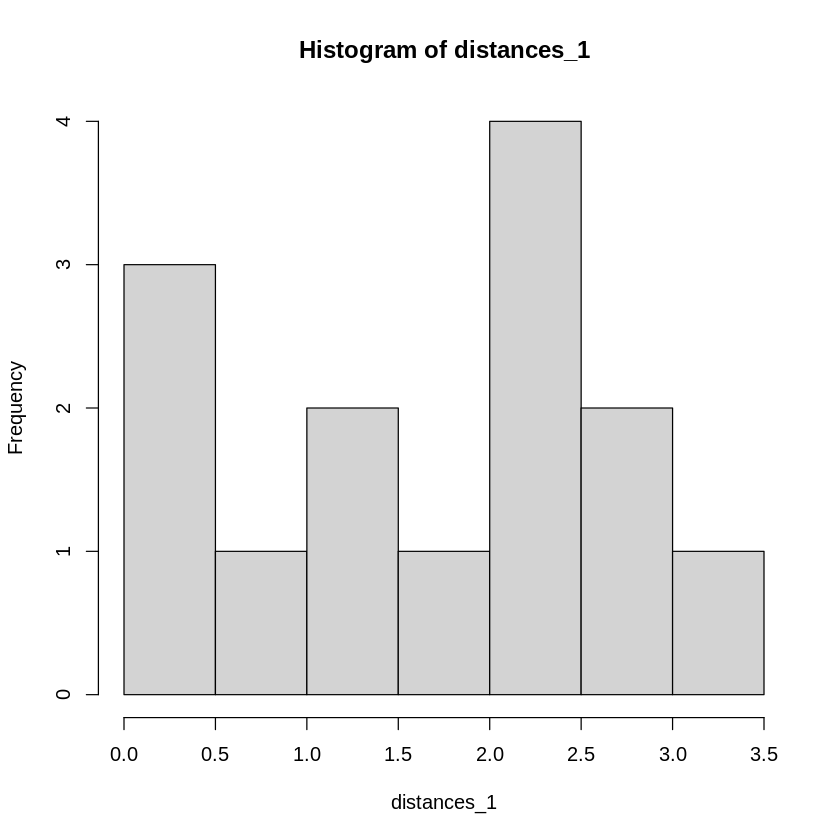

[1] "TrAGEDy DTW alignment [minimum cut - euclidean]: all  I I I I I I M M M W W W W M W W M I D I D I D"


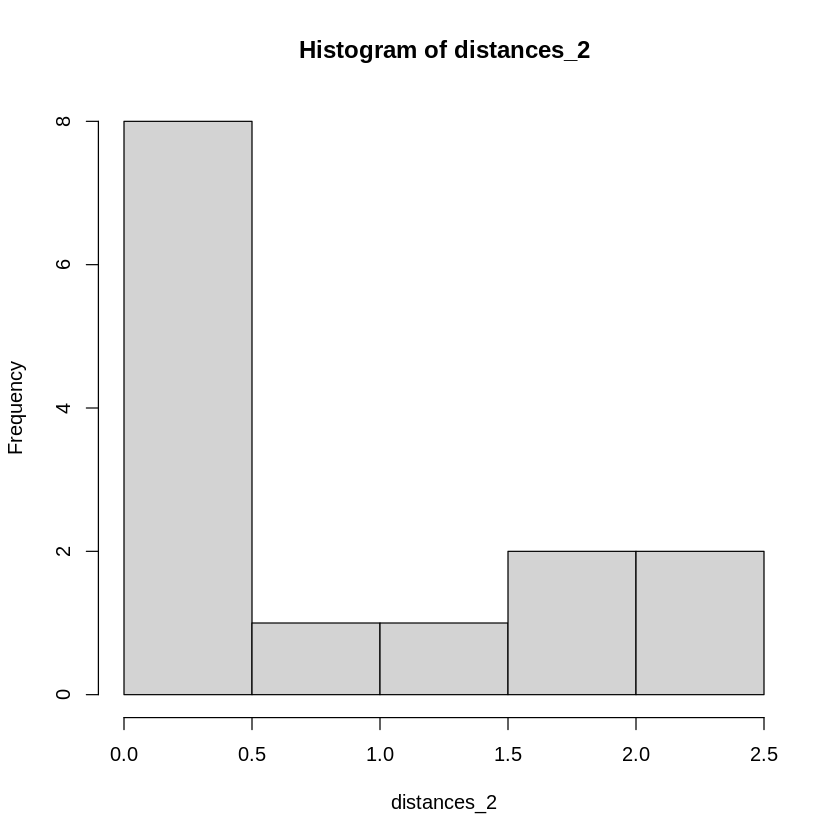

In [7]:
cut_type = 'minimum'
distance_metric = 'euclidean'
alignment <- run_tragedy_DTW_celllevel(WT_node_exp_mtx, KO_node_exp_mtx, cut_type = cut_type, distance_metric = distance_metric)
al_str <- get_5_state_alignment_str(alignment)
print(paste('TrAGEDy DTW alignment [minimum cut - euclidean]: all', al_str))


# Additional test - Healthy vs. IPF

In [92]:
numPts = 13
npts = numPts
R = sceasy::convertFormat('g2g_datasets_to_test/adata_healthy.h5ad', from="anndata", to="seurat")
Q = sceasy::convertFormat('g2g_datasets_to_test/adata_IPF.h5ad', from="anndata", to="seurat")
R_data = R@assays$RNA@data
Q_data = Q@assays$RNA@data
R_time = R$time
Q_time = Q$time

# CellAlign
interGlobalPAM = cellAlign::interWeights(expDataBatch = R_data, trajCond = R_time,
                                             winSz = 0.1, numPts = numPts)
interGlobalLPS = cellAlign::interWeights(expDataBatch = Q_data, trajCond = Q_time,
                                                 winSz = 0.1, numPts = numPts)
interScaledGlobalLPS = cellAlign::scaleInterpolate(interGlobalLPS)
interScaledGlobalPAM = cellAlign::scaleInterpolate(interGlobalPAM)

# Chekcking HHEX DTW alignment (for G2G manuscript Fig 3a)
#alignment = suppressMessages(run_global_dtw('HHEX', interGlobalLPS, interGlobalPAM, interScaledGlobalLPS, interScaledGlobalPAM )) 
#al_str = get_3_state_alignment_str(alignment)
#print(paste('CellAlign DTW alignment: HHEX: ', al_str))
# Checking all TFs
alignment = suppressMessages(run_global_dtw_all_genes(interGlobalLPS, interGlobalPAM, interScaledGlobalLPS, interScaledGlobalPAM )) 
al_str = get_3_state_alignment_str(alignment)
print(paste('CellAlign DTW alignment: all: ', al_str))

X -> counts

X -> counts



[1] "CellAlign DTW alignment: all:   M V M M V V W W W M V V V V V V W W W W W W"


In [94]:
dim(R)
dim(Q)

[1]  994 3157

[1] 994 890

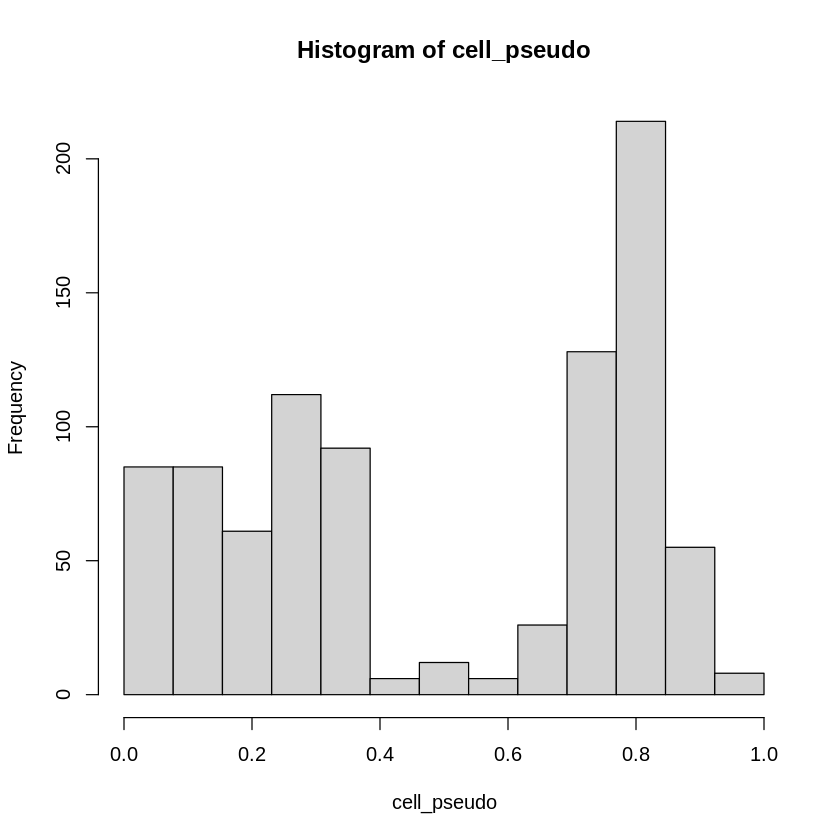

[1]  994 3157

[1] 994 890

[1] "The mean score of your optimal path is 7.34333087037543. You should consider whether or not these two processes share a common process"


Warning message in get_thresholds(alignment, dis_mtx, method):
“NAs introduced by coercion”
Warning message in get_thresholds(alignment, dis_mtx, method):
“NAs introduced by coercion”


[1] "TrAGEDy DTW alignment [minimum cut - euclidean]: all  M V M M M M M M V V I I I D D D D D D"


Warning message in if (index_choice == 1) {:
“the condition has length > 1 and only the first element will be used”
Warning message in penalty_mtx[, 1] == choice[index_choice]:
“longer object length is not a multiple of shorter object length”
Warning message in get_thresholds(alignment, dis_mtx, method):
“NAs introduced by coercion”
Warning message in get_thresholds(alignment, dis_mtx, method):
“NAs introduced by coercion”


[1] "TrAGEDy DTW alignment [minimum cut - spearman]: all  M V M M M M M M I I I I D I D D D D D"


png 
  2

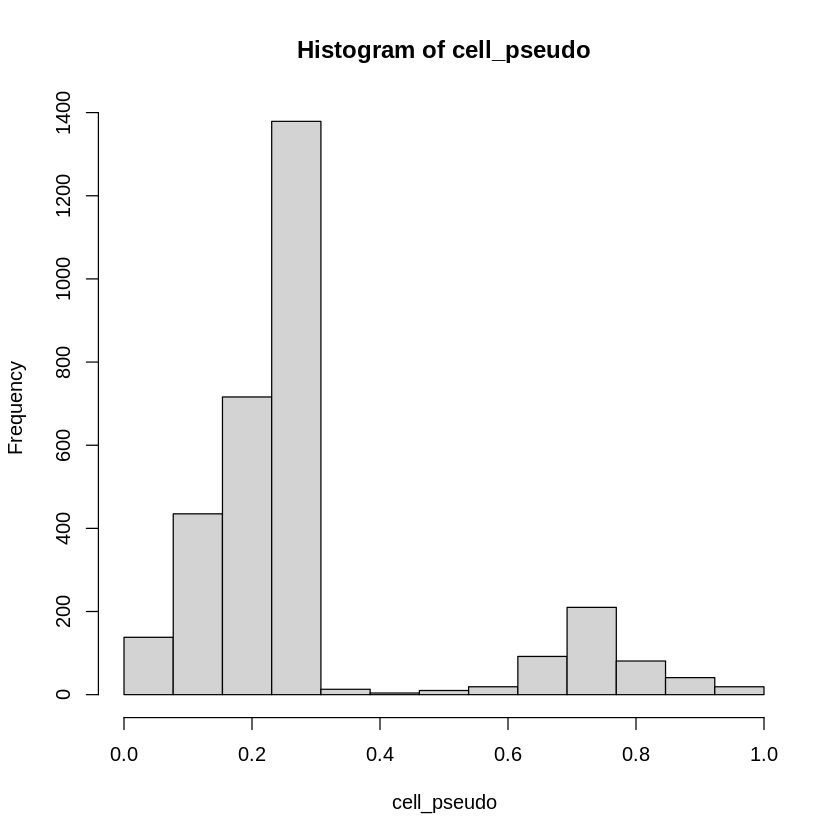

In [97]:


# TrAGEDy
pseudo_end <- min(c(max(Q_time, R_time)))
window <- 0.1 # we use 0.1 the same window size for benchmarking (as CellAlign, G2G also use that as default)
WT_cell_pseudotime <- matrix(R_time, dimnames =list(row.names(R@meta.data)  ))
KO_cell_pseudotime <- matrix(Q_time, dimnames =list(row.names(Q@meta.data)  ))
WT_ID <- data.frame(R@meta.data$ANNOTATION, row.names =row.names(R@meta.data))
KO_ID <- data.frame(Q@meta.data$ANNOTATION, row.names =row.names(Q@meta.data))
WT_tree <- nodePseudotime(WT_cell_pseudotime,WT_ID, numPts, "WT")
KO_tree <- nodePseudotime(KO_cell_pseudotime,KO_ID, numPts, "KO")
KO_cell_pseudo <- data.frame("ID" = row.names(Q@meta.data), "pseudo" =  Q_time)
KO_node_pseudo <- data.frame("ID" = row.names(KO_tree$pseudotime), "pseudo" = KO_tree$pseudotime$pseudotime)
WT_cell_pseudo <- data.frame("ID" = row.names(R@meta.data), "pseudo" = R_time)
WT_node_pseudo <- data.frame("ID" = row.names(WT_tree$pseudotime), "pseudo" = WT_tree$pseudotime$pseudotime)
KO_node_pseudotime <- matrix(KO_tree$pseudotime$pseudotime , dimnames = list(row.names(KO_tree$pseudotime)), )
WT_node_pseudotime <- matrix(WT_tree$pseudotime$pseudotime , dimnames = list(row.names(WT_tree$pseudotime)), )
#Get gene expression values for the interpolated points
KO_node_exp_mtx <- nodeExpressionEstimate(Q_data, KO_node_pseudotime, KO_cell_pseudotime, window, adjust.window = T)
WT_node_exp_mtx <- nodeExpressionEstimate(R_data, WT_node_pseudotime, WT_cell_pseudotime, window, adjust.window = T)

dim(R)
dim(Q)

dev.new()

cut_type = 'minimum'
distance_metric = 'euclidean'
alignment <- run_tragedy_DTW_celllevel(WT_node_exp_mtx, KO_node_exp_mtx, cut_type = cut_type, distance_metric = distance_metric)
al_str <- get_5_state_alignment_str(alignment)
print(paste('TrAGEDy DTW alignment [minimum cut - euclidean]: all', al_str))


cut_type = 'minimum'
distance_metric = 'spearman'
alignment <- run_tragedy_DTW_celllevel(WT_node_exp_mtx, KO_node_exp_mtx, cut_type = cut_type, distance_metric = distance_metric)
al_str <- get_5_state_alignment_str(alignment)
print(paste('TrAGEDy DTW alignment [minimum cut - spearman]: all', al_str))


dev.off()
device_list <- dev.list()
for (i in device_list) {
    dev.off(i)
}    